In [1]:
import json
import pandas as pd
import gensim
import zipfile
import wget
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных

In [3]:
def count_stat(a, count=None):
    if count is None: count = 0
    for key in a:
        if isinstance(a[key], dict):
            count = count_stat(a[key], count)
        else:
            count += a[key]
    return count

In [138]:
def get_all_data(json_data):
    all_data = dict()

    for verb in json_data:
        for adp in json_data[verb]:
            for case in json_data[verb][adp]:
                vg = f"{adp}_{case}"
                if vg not in all_data:
                    all_data[vg] = dict()
                all_data[vg][verb] = json_data[verb][adp][case]
    return all_data    

### Песочница

In [31]:
data = {
    "на_Loc": {
        "бегать": json_data['бегать']['на']['Loc'],
        "бежать": json_data['бежать']['на']['Loc'],
        "нестись": json_data['нестись']['на']['Loc']
    }
}

### 60 глаголов движения

In [2]:
with open('./run_verbs.json', 'r', encoding='UTF-8') as f:
    json_data = json.load(f)

In [4]:
noun = set()
for verb in json_data:
    for adp in json_data[verb]:
        for case in json_data[verb][adp]:
            noun.update(json_data[verb][adp][case])

In [5]:
len(noun)

14729

In [6]:
case_dict = dict()
for verb in json_data:
    for adp in json_data[verb]:
        for case in json_data[verb][adp]:
            if case not in case_dict:
                case_dict[case] = 1
            else:
                case_dict[case] += 1
case_dict

{'Acc': 118, 'Ins': 73, 'Gen': 141, 'Loc': 74, 'Dat': 71}

In [7]:
json_data.keys()

dict_keys(['идти', 'войти', 'носить', 'выходить', 'лезть', 'выйти', 'бежать', 'вести', 'вылезти', 'тащить', 'носиться', 'лететь', 'гнаться', 'ехать', 'ходить', 'выехать', 'внести', 'вбежать', 'катиться', 'нестись', 'кататься', 'водить', 'ездить', 'бегать', 'входить', 'нести', 'лазить', 'вылететь', 'вылетать', 'въехать', 'блуждать', 'выбежать', 'выбегать', 'бродить', 'плавать', 'гоняться', 'гулять', 'брести', 'гнать', 'летать', 'плыть', 'ползти', 'катить', 'ползать', 'везти', 'влететь', 'втащить', 'таскать', 'выезжать', 'влезать', 'гонять', 'въезжать', 'возить', 'катать', 'вылезать', 'таскаться', 'вносить', 'ввезти', 'влезть', 'влетать', 'ввозить'])

In [139]:
all_data = get_all_data(json_data)

In [140]:
len(all_data) #всего разных управлений

53

In [141]:
len(all_data["на_Loc"]) #30 глаголов, которые используются с таким управлением

30

### 222 глагола движения

In [137]:
with open('./run_verbs_2.json', 'r', encoding='UTF-8') as f:
    json_data_2 = json.load(f)

In [142]:
all_data_2 = get_all_data(json_data_2)

In [143]:
len(all_data_2) 

58

In [144]:
len(all_data_2["на_Loc"]) 

92

### Глаголы мысли

In [164]:
with open('./think_verbs_1.json', 'r', encoding='UTF-8') as f:
    json_data_3 = json.load(f)

In [165]:
all_data_think = get_all_data(json_data_3)

In [166]:
len(all_data_think) 

42

# Эмбеддинги, [туториал](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb)

использую [генсим](https://radimrehurek.com/gensim/models/word2vec.html) 

In [16]:
from gensim.test.utils import get_tmpfile
from gensim.models import FastText

In [15]:
def get_model_word2vec(model_file):
    with zipfile.ZipFile(model_file, 'r') as archive:
        stream = archive.open('model.bin')
        model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)
    return model    

In [17]:
def get_model_fasttext(model_file):
    model = gensim.models.KeyedVectors.load(model_file + "/model.model")
    return model  

In [18]:
models = [
    {
        "model": get_model_word2vec("180.zip"),
        "name": "ruscorpora_upos_cbow_300_20_2019",
        "type": "word2vec"
    },
    {
        "model": get_model_word2vec("220.zip"),
        "name": "ruwikiruscorpora_upos_cbow_300_10_2021",
        "type": "word2vec"
    },
    {
        "model": get_model_fasttext("213"),
        "name": "geowac_lemmas_none_fasttextskipgram_300_5_2020",
        "type": "fasttext"
    },
    {
        "model": get_model_fasttext("214"),
        "name": "geowac_tokens_none_fasttextskipgram_300_5_2020",
        "type": "fasttext"
    },
    {
        "model": get_model_word2vec("185.zip"),
        "name": "tayga_upos_skipgram_300_2_2019",
        "type": "word2vec"
    },
    {
        "model": get_model_fasttext("187"),
        "name": "tayga_none_fasttextcbow_300_10_2019",
        "type": "fasttext"
    }
]

In [19]:
def normalize_word(text):
    return text + "_NOUN"    

In [20]:
def get_embedding(data, model, mode="word2vec"):  
    vectors = list()
    words = list()
    
    #total = count_stat(data)
    
    for i, word in enumerate(data):        
        try:
            if mode == "word2vec":
                v = model[normalize_word(word)]
            elif mode == "fasttext":
                v = model[word]
            #v = v * (data[word] / total)
            vectors.append(v)
            words.append(word)
        except (KeyError, ValueError, AttributeError):
            continue
    
    return vectors, words

### Песочница

In [32]:
len(data['на_Loc']['бегать'])

77

In [33]:
X, words = get_embedding(data['на_Loc']['бегать'], models[0]["model"])

In [34]:
print(len(X), len(words))

74 74


# [Визуализация](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)

In [49]:
from sklearn.manifold import TSNE

In [50]:
def tsne_draw(data):
    plt.figure(figsize=(10,5))
    sns.scatterplot(
        data=data,
        legend="full",
        alpha=1
    )

### Песочница

In [51]:
X_tsne_embedded = TSNE(n_components=2, init='random').fit_transform(X)

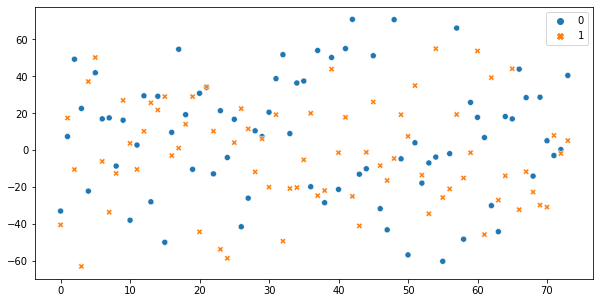

In [52]:
tsne_draw(X_tsne_embedded)

# Кластеризация

In [35]:
def clusters_dict(data, labels):
    new_dict = {}

    for i, word in enumerate(data):
        if labels[i] not in new_dict:
            new_dict[labels[i]] = list()
        new_dict[labels[i]].append(word)
    return new_dict

In [36]:
def print_clusters(data):
    for key in sorted(data):
        res_list = " ".join(data[key])
        print(f"{key}: {res_list}")

In [37]:
def visualization(X, labels, words, embeddings_name, title, old_pal=None):
    
    data = pd.DataFrame(X, columns=['tsne1','tsne2'])
    data['label'] = labels
    data['words'] = words
    
    if old_pal is None:
        pal = sns.color_palette('hls', len(data['label'].unique()))
    else:
        clusters = data['label'].unique()
        pal = dict()
        for i in range(len(old_pal)):
            if i in clusters:
                pal[i] = old_pal[i]
    
    plt.figure(figsize=(14, 7))
    plt.margins(0.1)

    p1 = sns.scatterplot(x='tsne1', # Horizontal axis
                         y='tsne2', # Vertical axis
                         data=data, # Data source
                         hue='label',
                         legend=False,
                         palette=pal)
    
    plt.xlabel(f"Координата x ({embeddings_name})")
    plt.ylabel(f"Координата y ({embeddings_name})")
    plt.title(title)

    for line in range(0, data.shape[0]):
        p1.text(data.tsne1[line] + 0.3, data.tsne2[line] - 0.3, 
                data.words[line], horizontalalignment='left', 
                size='medium', color=pal[data.label[line]], weight='semibold')
        
    return pal

## Кластеризация KMeans

In [38]:
from sklearn.cluster import KMeans

In [39]:
def check_cluster_dict(cluster_dict, word_1, word_2):
    for key in cluster_dict:    
        if word_1 in cluster_dict[key] and word_2 in cluster_dict[key]:
            return True
    return False

In [40]:
def find_min_clusters(clusters_list, words):
    res_list = list()
    ind_list = list()
    i = 0
    while i < len(words) - 1:
        if i not in ind_list:
            temp_list = list()
            temp_list.append(words[i])
            j = i + 1
            while j < len(words):
                for key in clusters_list[0]:
                    flag = False
                    if words[i] in clusters_list[0][key]:
                        if words[j] in clusters_list[0][key]:
                            count = 1
                            for cluster_ind in range(1, len(clusters_list)):
                                if check_cluster_dict(clusters_list[cluster_ind], words[i], words[j]) is True:
                                    count += 1
                                else:
                                    break
                            if count == len(clusters_list):
                                temp_list.append(words[j])
                                ind_list.append(j)
                                flag = True              
                    if flag is True:
                        break  
                j += 1
            if len(temp_list) > 1:
                res_list.append(temp_list)
        i += 1
    return res_list

In [41]:
def kmeans_experiment(model, data, n_clusters):
    X, words = get_embedding(data, model["model"], model["type"])
    
    X_tsne_embedded = TSNE(n_components=2, init='random').fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X) 
    labels = kmeans.labels_
    
    cluster_dict = clusters_dict(words, labels)
    
    return cluster_dict

## Способ нахождения минимальных семантических кластеров 

In [42]:
def find_min_clusters_on_kmeans(data, n_clusters):    
    result_dict = dict()
    
    for vg in data:
        result_dict[vg] = dict()
        for verb in data[vg]:
            clusters_list = list()
            for i in range(len(models)):
                if isinstance(n_clusters, int):
                    cluster_dict_temp = kmeans_experiment(models[i], data[vg][verb], n_clusters) 
                elif isinstance(n_clusters, dict):
                    cluster_dict_temp = kmeans_experiment(models[i], data[vg][verb], n_clusters[vg][verb][i]) 
                clusters_list.append(cluster_dict_temp)
            result_dict[vg][verb] = find_min_clusters(clusters_list, list(data[vg][verb]))
                
    return result_dict

In [43]:
def print_min_clusters(res_dict):
    for vg in res_dict:
        print(vg)
        for verb in res_dict[vg]:
            print("\t", verb, len(res_dict[vg][verb]))
            for cluster in res_dict[vg][verb]:
                print("\t\t", cluster)

### Песочница. Пробую на 6 кластерах

In [105]:
experiment_1 = find_min_clusters_on_kmeans(data, 6)

In [106]:
print_min_clusters(experiment_1)

на_Loc
	 бегать 11
		 ['голова', 'нога', 'щека', 'ножка', 'лапа']
		 ['свобода', 'пари', 'дело', 'воля', 'пара', 'перемена', 'бал', 'выставка']
		 ['пляж', 'вилла']
		 ['протяжение', 'водород']
		 ['место', 'часть']
		 ['физкультура', 'пересдача']
		 ['ферма', 'земля', 'территория']
		 ['участок', 'поле']
		 ['экран', 'монитор']
		 ['балкон', 'этаж', 'крыша']
		 ['чемпионат', 'соревнование']
	 бежать 13
		 ['буксир', 'лодка', 'катер', 'яхта', 'корабль', 'шлюпка']
		 ['шпилька', 'каблук', 'каблучок', 'носок']
		 ['предел', 'расстояние', 'возвышенность', 'уровень']
		 ['нога', 'лапка', 'ладонь', 'спина']
		 ['колесо', 'лыжа']
		 ['скорость', 'высота']
		 ['грузовик', 'танк']
		 ['экран', 'кадр']
		 ['отрезок', 'путь']
		 ['телек', 'таймер']
		 ['собеседование', 'лекция']
		 ['марафон', 'тренировка', 'матч']
		 ['восток', 'направление']
	 нестись 9
		 ['качели', 'горка']
		 ['ягуар', 'олень']
		 ['спина', 'лапа']
		 ['экран', 'монитор']
		 ['поворот', 'путь']
		 ['крыло', 'шип']
		 ['шоу'

### Песочница. Пробую на 10 кластерах

In [113]:
print_min_clusters(find_min_clusters_on_kmeans(data, 10))

на_Loc
	 бегать 7
		 ['голова', 'мышка', 'поводок']
		 ['свобода', 'дело', 'воля']
		 ['лапка', 'нога', 'ножка', 'лапа']
		 ['море', 'побережье']
		 ['карусель', 'сцена']
		 ['лента', 'карта']
		 ['чемпионат', 'соревнование']
	 бежать 10
		 ['буксир', 'катер', 'корабль']
		 ['шпилька', 'каблук']
		 ['лодка', 'шлюпка']
		 ['монитор', 'экран']
		 ['рука', 'ладонь']
		 ['нога', 'лапка', 'спина']
		 ['грузовик', 'танк']
		 ['лицо', 'глаз']
		 ['кадр', 'фон']
		 ['путь', 'уровень']
	 нестись 6
		 ['поезд', 'мотоцикл', 'такси', 'грузовик']
		 ['пара', 'пар']
		 ['карусель', 'горка']
		 ['лошадь', 'колесница', 'конь']
		 ['шоссе', 'руль']
		 ['буксир', 'судно']


## Подбор кол-ва кластеров с помощью AffinityPropagation

In [44]:
from sklearn.cluster import AffinityPropagation

In [45]:
def affinity_propagation_experiment(model, data):
    X, words = get_embedding(data, model["model"], model["type"])
    
    affinity_propagation = AffinityPropagation().fit(X)
    labels = affinity_propagation.labels_  
    
    return len(affinity_propagation.cluster_centers_)

In [46]:
def affinity_propagation_num_clusters_list(data):
    result_dict = dict()  
    for vg in data:
        result_dict[vg] = dict()
        for verb in data[vg]: 
            num_clusters_list = list()  
            for i in range(len(models)):
                cluster_dict_temp = affinity_propagation_experiment(models[i], data[vg][verb])
                num_clusters_list.append(cluster_dict_temp)
            result_dict[vg][verb] = num_clusters_list
    return result_dict

### Песочница

In [91]:
affinity_propagation_num_clusters_list(data)

{'на_Loc': {'бегать': [5, 8, 10, 10, 15, 16],
  'бежать': [5, 10, 13, 12, 14, 17],
  'нестись': [6, 7, 11, 9, 11, 12]}}

Отмечаю, что 6 как количество кластеров нигде не встретилось. Пробую эти значения кластеров передавать kmeans

In [75]:
ap_num_clusters_data = affinity_propagation_num_clusters_list(data)

In [76]:
experiment_data = find_min_clusters_on_kmeans(data, ap_num_clusters_data)

In [77]:
print_min_clusters(experiment_data)

на_Loc
	 бегать 6
		 ['лапка', 'нога', 'ножка', 'лапа']
		 ['лужайка', 'дорожка', 'площадка']
		 ['море', 'побережье']
		 ['территория', 'часть']
		 ['мышка', 'поводок']
		 ['чемпионат', 'соревнование']
	 бежать 7
		 ['буксир', 'катер', 'корабль']
		 ['шпилька', 'каблук']
		 ['лодка', 'яхта', 'шлюпка']
		 ['монитор', 'телек']
		 ['рука', 'ладонь']
		 ['нога', 'лапка', 'ножка']
		 ['голова', 'спина']
	 нестись 6
		 ['поезд', 'машина', 'мотоцикл', 'грузовик']
		 ['качели', 'карусель', 'горка']
		 ['экран', 'монитор']
		 ['санки', 'сноуборд']
		 ['буксир', 'судно']
		 ['кадр', 'снимок']


Кластеров становится меньше (по количеству и размеру), но они более осмысленные!

### 60 глаголов движения

In [47]:
%%time
ap_num_clusters_run_verb_1 = affinity_propagation_num_clusters_list(all_data)

CPU times: user 10min 54s, sys: 5min 46s, total: 16min 41s
Wall time: 6min 33s


In [53]:
%%time
experiment_run_verb_1 = find_min_clusters_on_kmeans(all_data, ap_num_clusters_run_verb_1)

CPU times: user 2h 40min 35s, sys: 1h 5min 40s, total: 3h 46min 16s
Wall time: 1h 48min 6s


In [55]:
len(experiment_run_verb_1['на_Loc'].keys())

30

### 222 глагола движения

In [145]:
%%time
ap_num_clusters_run_verbs_2 = affinity_propagation_num_clusters_list(all_data_2)

CPU times: user 30min 2s, sys: 17min 19s, total: 47min 22s
Wall time: 17min 7s


In [146]:
%%time
experiment_run_verbs_2 = find_min_clusters_on_kmeans(all_data_2, ap_num_clusters_run_verbs_2)

CPU times: user 10h 20min 8s, sys: 4h 20min 33s, total: 14h 40min 42s
Wall time: 7h 3min 43s


In [147]:
len(experiment_run_verbs_2['на_Loc'].keys())

92

### Глаголы мышления

In [167]:
%%time
ap_num_clusters_think = affinity_propagation_num_clusters_list(all_data_think)

CPU times: user 11min 15s, sys: 4min 56s, total: 16min 12s
Wall time: 8min


In [168]:
%%time
experiment_think = find_min_clusters_on_kmeans(all_data_think, ap_num_clusters_think)

CPU times: user 2h 38min, sys: 57min 28s, total: 3h 35min 28s
Wall time: 1h 45min 21s


In [169]:
len(experiment_think.keys())

42

# Данные для графа

У меня есть 2 набора данных: исходные существительные для "модель_управления + глагол" и минимальные кластеры для "модель_управления + глагол"

1) Создать множество существительных

2) Попарно перебираю множество существительных, считаю частоту встречаемости пары. Если 100 раз встретились вместе в исходных данных, то добавляю в словарь и сразу считаю, сколько раз эта пара встретилась в минимальных кластерах

3) Смотрю, сколько всего таких пар получилось 

- если мало, то думаю, как визуализировать
- если много, думаю, как отфильтровать

In [56]:
def set_of_noun(data):
    res_set = set()
    for vg in data:
        for verb in data[vg]:
            res_set.update(data[vg][verb].keys())
    return res_set

In [148]:
def count_pair(noun_set):
    count = 0
    noun_list = list(noun_set)
    for i in range(len(noun_list) - 1):
        for j in range(i + 1, len(noun_list)):
            count += 1
    return count

In [195]:
def get_frequency_of_collocations(input_data, cluster_data, threshold_value):
    res_list = list()
    
    noun_list = list(set_of_noun(input_data))
    for i in range(len(noun_list) - 1):
        for j in range(i + 1, len(noun_list)):
            count_all = 0            
            for vg in input_data:
                for verb in input_data[vg]:
                    if noun_list[i] in input_data[vg][verb]:
                        if noun_list[j] in input_data[vg][verb]:
                            count_all += 1
            if count_all >= threshold_value:
                count_cluster = 0
                for vg in cluster_data:
                    for verb in cluster_data[vg]:
                        for cluster_ind in range(len(cluster_data[vg][verb])):
                            if noun_list[i] in cluster_data[vg][verb][cluster_ind]:
                                if noun_list[j] in cluster_data[vg][verb][cluster_ind]:
                                    count_cluster += 1
                                else:
                                    break                
                if count_cluster > 0:
                    res_list.append([noun_list[i], noun_list[j], count_all, count_cluster, count_cluster/count_all])                               
    return res_list

In [151]:
def get_frequency_of_nouns(input_data):
    noun_dict = dict()
    
    noun_list = list(set_of_noun(input_data))
    for i in range(len(noun_list)):
        count = 0
        for vg in input_data:
            for verb in input_data[vg]:
                if noun_list[i] in input_data[vg][verb]:
                    count += 1
        noun_dict[noun_list[i]] = count
    return noun_dict

### 60 глаголов

In [149]:
%%time
noun_set_run_verb_1 = set_of_noun(all_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.66 ms


In [150]:
%%time
pair_count_run_verb_1 = count_pair(noun_set_run_verb_1)
print(pair_count_run_verb_1)

108464356
CPU times: user 7.86 s, sys: 93.8 ms, total: 7.95 s
Wall time: 7.93 s


In [121]:
%%time
frequency_run_verb_1 = get_frequency_of_collocations(all_data, experiment_run_verb_1)

CPU times: user 2h 13min 47s, sys: 11.8 s, total: 2h 13min 59s
Wall time: 2h 16min 39s


In [124]:
len(frequency_run_verb_1)

103

получила 103 пары (больше 50 частота встречаемости вообще и больше 0 по кластерам)

In [127]:
df = pd.DataFrame(frequency_run_verb_1, columns=['word_1', 'word_2', 'frequency_all', 'frequency_cluster', 'proportion'])

In [128]:
df.head()

,word_1,word_2,frequency_all,frequency_cluster,proportion
0,девушка,женщина,57,27,0.473684
1,полоса,дорога,60,1,0.016667
2,площадь,участок,54,1,0.018519
3,площадь,улица,72,8,0.111111
4,площадь,станция,56,1,0.017857


In [136]:
df.to_csv('collacation_frequency_1.csv', index=False)

In [153]:
frequency_noun_run_verb_1 = get_frequency_of_nouns(all_data)

In [154]:
with open('./noun_of_run_verbs_1.json', 'w', encoding='UTF-8') as f:
    json.dump(frequency_noun_run_verb_1, f)

### 222 глагола

In [155]:
%%time
noun_set_run_verb_2 = set_of_noun(all_data_2)

CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 20.4 ms


In [156]:
%%time
pair_count_run_verb_2 = count_pair(noun_set_run_verb_2)
print(pair_count_run_verb_2)

246897531
CPU times: user 17.5 s, sys: 15.6 ms, total: 17.5 s
Wall time: 17.6 s


In [157]:
%%time
frequency_run_verb_2 = get_frequency_of_collocations(all_data_2, experiment_run_verbs_2)

CPU times: user 1d 1h 11min 38s, sys: 2min 38s, total: 1d 1h 14min 16s
Wall time: 1d 1h 31min 59s


In [158]:
len(frequency_run_verb_2)

4173

Получила 4173 пары. (больше 30 частота встречаемости вообще, больше 0 по кластерам)

In [159]:
df_run_verb_2 = pd.DataFrame(frequency_run_verb_2, columns=['word_1', 'word_2', 'frequency_all', 'frequency_cluster', 'proportion'])

In [160]:
df_run_verb_2.head()

,word_1,word_2,frequency_all,frequency_cluster,proportion
0,обход,место,42,1,0.023810
1,девушка,хозяйка,56,2,0.035714
2,девушка,сестра,111,2,0.018018
3,девушка,супруг,34,1,0.029412
4,девушка,леди,57,2,0.035088


In [161]:
df_run_verb_2.to_csv('collacation_frequency_run_verb_2.csv', index=False)

In [162]:
frequency_noun_run_verb_2 = get_frequency_of_nouns(all_data_2)

In [163]:
with open('./noun_of_run_verbs_2.json', 'w', encoding='UTF-8') as f:
    json.dump(frequency_noun_run_verb_2, f)

### Считаю для управления "на Loc"

In [190]:
len(all_data_2['на_Loc'])

92

In [191]:
all_data_vg_1 = {
    'на_Loc': all_data_2['на_Loc']
}

experiment_run_verbs_vg_1 = {
    'на_Loc': experiment_run_verbs_2['на_Loc']
}

In [199]:
len(all_data_2['на_Loc'])

92

In [208]:
%%time
frequency_run_verb_vg_1 = get_frequency_of_collocations(all_data_vg_1, experiment_run_verbs_vg_1, 10)

CPU times: user 30.2 s, sys: 0 ns, total: 30.2 s
Wall time: 30.4 s


In [209]:
len(frequency_run_verb_vg_1)

231

In [210]:
df_run_verb_vg_1 = pd.DataFrame(frequency_run_verb_vg_1, columns=['word_1', 'word_2', 'frequency_all', 'frequency_cluster', 'proportion'])

In [211]:
df_run_verb_vg_1.head()

,word_1,word_2,frequency_all,frequency_cluster,proportion
0,северо-запад,восток,11,8,0.727273
1,скорость,поворот,14,1,0.071429
2,скорость,высота,26,1,0.038462
3,скорость,расстояние,28,1,0.035714
4,спина,нога,15,3,0.200000


In [212]:
df_run_verb_vg_1.to_csv('collacation_frequency_run_verb_vg_1.csv', index=False)

In [213]:
frequency_noun_run_verb_vg_1 = get_frequency_of_nouns(all_data_vg_1)

In [214]:
with open('./noun_of_run_verbs_vg_1.json', 'w', encoding='UTF-8') as f:
    json.dump(frequency_noun_run_verb_vg_1, f)

### Глаголы мышления

In [170]:
%%time
noun_set_think = set_of_noun(all_data_think)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.13 ms


In [171]:
%%time
pair_count_think = count_pair(noun_set_think)
print(pair_count_think)

85001241
CPU times: user 6.38 s, sys: 93.8 ms, total: 6.47 s
Wall time: 6.34 s


In [172]:
%%time
frequency_think = get_frequency_of_collocations(all_data_think, experiment_think)

CPU times: user 57min 19s, sys: 2.67 s, total: 57min 22s
Wall time: 57min 25s


In [173]:
len(frequency_think)

85

In [174]:
df_think = pd.DataFrame(frequency_think, columns=['word_1', 'word_2', 'frequency_all', 'frequency_cluster', 'proportion'])

In [175]:
df_think.head()

,word_1,word_2,frequency_all,frequency_cluster,proportion
0,девушка,женщина,45,12,0.266667
1,система,модель,36,1,0.027778
2,система,программа,33,1,0.030303
3,создание,проект,31,2,0.064516
4,книга,фильм,32,1,0.031250


In [176]:
df_think.to_csv('collacation_frequency_think.csv', index=False)

In [177]:
frequency_noun_think = get_frequency_of_nouns(all_data_think)

In [178]:
with open('./noun_of_think_verbs.json', 'w', encoding='UTF-8') as f:
    json.dump(frequency_noun_think, f)

### Проверяем, подходит ли этот метод по метрикам

In [111]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score

In [161]:
for i in range(len(all_data)):
    print(len(all_data[i]))

77
82
58


In [132]:
def calculate_metrics(data, models, start, end):
    res_dict = dict()
    
    for vg in data:
        res_dict[vg] = dict()
        for verb in data[vg]: 
            models_metrics = list()
            for ind in range(len(models)):                
                km_scores = []
                km_silhouette = []
                db_score = []

                X_scaled, words = get_embedding(data[vg][verb], models[ind]["model"], models[ind]["type"])

                for i in range(start, end):
                    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
                    preds = km.predict(X_scaled)
                    
                    km_scores.append(-km.score(X_scaled))                    
                    km_silhouette.append(silhouette_score(X_scaled, preds))
                    db_score.append(davies_bouldin_score(X_scaled, preds))
                models_metrics.append({
                    "km_scores": km_scores, 
                    "km_silhouette": km_silhouette, 
                    "db_score": db_score
                })
            res_dict[vg][verb] = models_metrics
    return res_dict

In [215]:
def show_metrics(metrics, ap_num_clusters):
    fig = plt.figure(figsize=(16,4)) 
    
    ax_1 = fig.add_subplot(1, 3, 1)
    ax_2 = fig.add_subplot(1, 3, 2)
    ax_3 = fig.add_subplot(1, 3, 3)

    X = [i for i in range(start, end)]

    ax_1.set(title="The elbow method")
    ax_1.scatter(x=X,y=metrics['km_scores'],s=80,edgecolor='k')
    ax_1.grid(True)
    ax_1.set(xlabel="Number of clusters")
    ax_1.set(ylabel="K-means score")
    ax_1.set(xticks=X)

    ax_2.set(title="The silhouette coefficient method")
    ax_2.scatter(x=X,y=metrics['km_silhouette'],s=80,edgecolor='k')
    ax_2.grid(True)
    ax_2.set(xlabel="Number of clusters")
    ax_2.set(ylabel="Silhouette score")
    ax_2.set(xticks=X)

    ax_3.set(title="Davies-Bouldin score")
    ax_3.scatter(x=X,y=metrics['db_score'],s=80,edgecolor='k')
    ax_3.grid(True)
    ax_3.set(xlabel="Number of clusters")
    ax_3.set(ylabel="Davies-Bouldin score")
    ax_3.set(xticks=X)
    
    fig.suptitle(f"Number of clusters = {ap_num_clusters} (AffinityPropagation)\n\n", fontsize=14)

In [202]:
start, end = 2, 20

In [203]:
ap_num_clusters

{'на_Loc': {'бегать': [5, 8, 10, 10, 15, 16],
  'бежать': [5, 10, 13, 12, 14, 17],
  'нестись': [6, 7, 11, 9, 11, 12]}}

In [205]:
metrics = calculate_metrics(data, models, start, end)

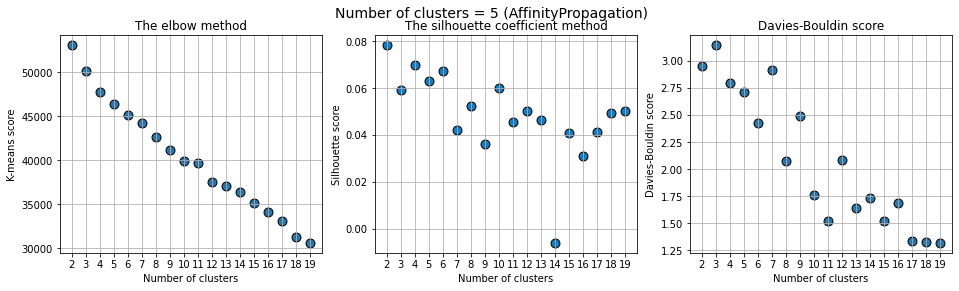

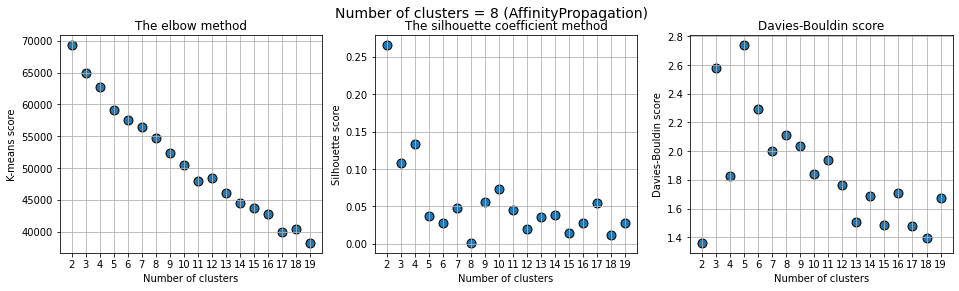

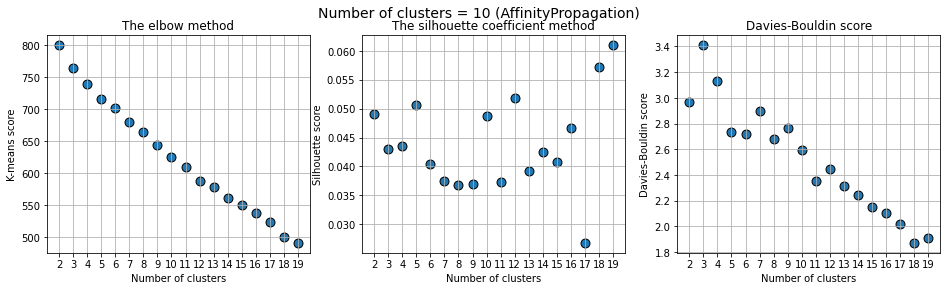

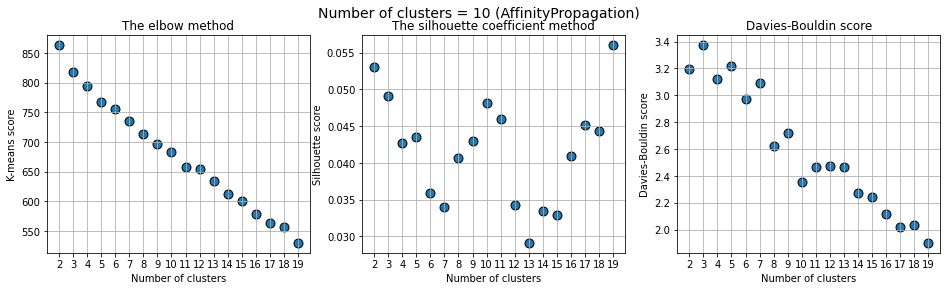

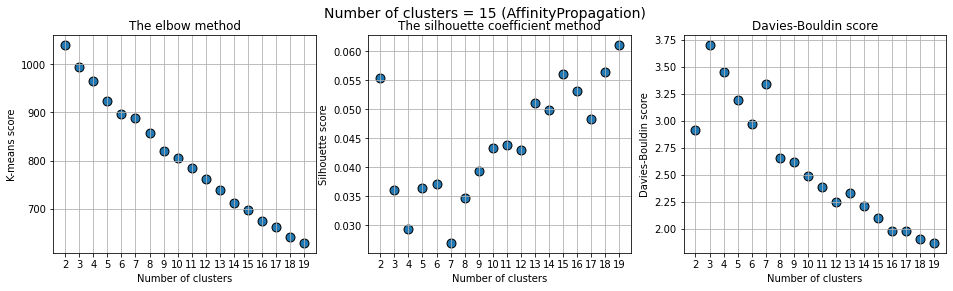

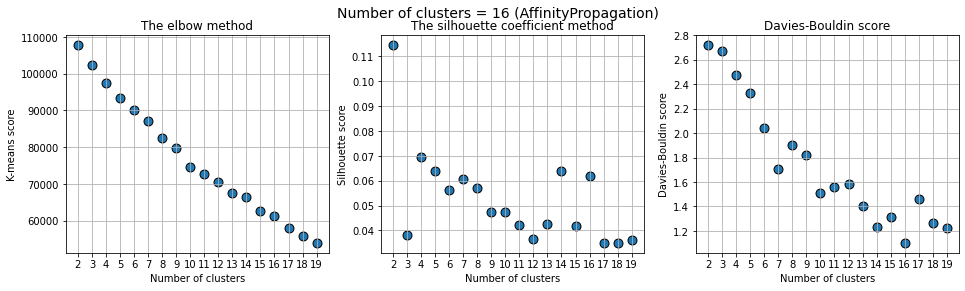

In [216]:
for i in range(6):
    show_metrics(metrics['на_Loc']['бегать'][i], ap_num_clusters['на_Loc']['бегать'][i])

В некоторых случаях можно сказать, что количество кластеров, предложенное AffinityPropagation, совпадает с метрикой Дэвиса-Болдина или коэффициентом силуэтта